In [ ]:
!pip install yfinance
!pip install pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importando y leyendo los datos

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Visualizando y limpiando los datos**

In [ ]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo("^IXIC", start="2000-01-01", end="2022-11-11")

[*********************100%***********************]  1 of 1 completed


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,4186.189941,4192.189941,3989.709961,4131.149902,4131.149902,1510070000
2000-01-04,4020.000000,4073.250000,3898.229980,3901.689941,3901.689941,1511840000
2000-01-05,3854.350098,3924.209961,3734.870117,3877.540039,3877.540039,1735670000
2000-01-06,3834.439941,3868.760010,3715.620117,3727.129883,3727.129883,1598320000
2000-01-07,3711.090088,3882.669922,3711.090088,3882.620117,3882.620117,1634930000
...,...,...,...,...,...,...
2022-11-04,10548.139648,10553.629883,10262.929688,10475.250000,10475.250000,5453750000
2022-11-07,10516.940430,10587.959961,10428.910156,10564.519531,10564.519531,4456690000
2022-11-08,10611.530273,10745.639648,10472.730469,10616.200195,10616.200195,5134500000


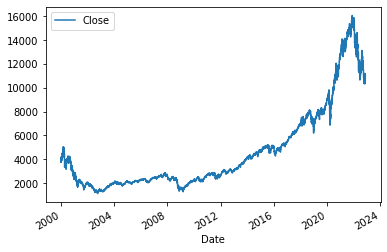

In [ ]:
data.plot.line(y='Close', use_index=True)

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Encontrando los terminos del modelo ARIMA

## d: el numero de la diferencia requerida para hacer la serie de tiempo estacionaria (I)


In [ ]:
from pmdarima.arima.utils import ndiffs
ndiffs(data.Close, test='adf')

1

Encontramos la diferencia para la serie de tiempo con la ayuda de ndiffs

## p: el orden de la auto regresion (AR)
 

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


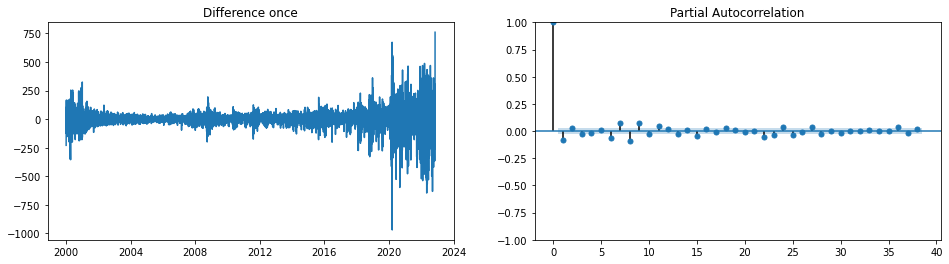

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
diff = data.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,4))
ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0,1)
plot_pacf(diff, ax = ax2);

**Para la gráfica PACF, dado que hay una caída sustancial en el retraso uno, que está correlacionada negativamente, también usaremos un factor AR de 1**

## q: el orden de las medias moviles (MA)

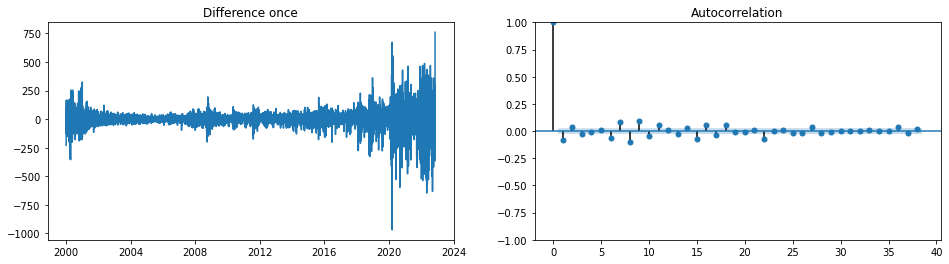

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
diff = data.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,4))
ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0,0.5)
plot_acf(diff, ax = ax2);

Dado que el primer retraso es negativo y el segundo retraso es positivo, utilizaremos el primer retraso como punto de media móvil.

In [ ]:
# test split
row = int(len(data)*0.9)
train = list(data[0:row]['Close'])
test = list(data[row:]['Close'])

In [ ]:
print(len(train))
print(len(test))

5177
576


In [ ]:
# fit model
spy_arima = ARIMA(train, order=(1,1,1))
spy_arima_fit = spy_arima.fit()
print(spy_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5177
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -28572.396
Date:                Tue, 15 Nov 2022   AIC                          57150.792
Time:                        22:52:37   BIC                          57170.448
Sample:                             0   HQIC                         57157.669
                               - 5177                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3301      0.024    -13.590      0.000      -0.378      -0.283
ma.L1          0.1870      0.026      7.118      0.000       0.136       0.238
sigma2      3650.2136     19.726    185.048      0.0

In [ ]:
# Creando una lista de valores de train
history = [x for x in train]
# lista de prediciones
model_predictions = []
# Contando el numero de observaciones
N_test_observations = len(test)
# un loop a traves de cada dato
for i in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[i]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))
%store model_predictions

Testing Mean Squared Error is 155.26537645202143
Stored 'model_predictions' (list)


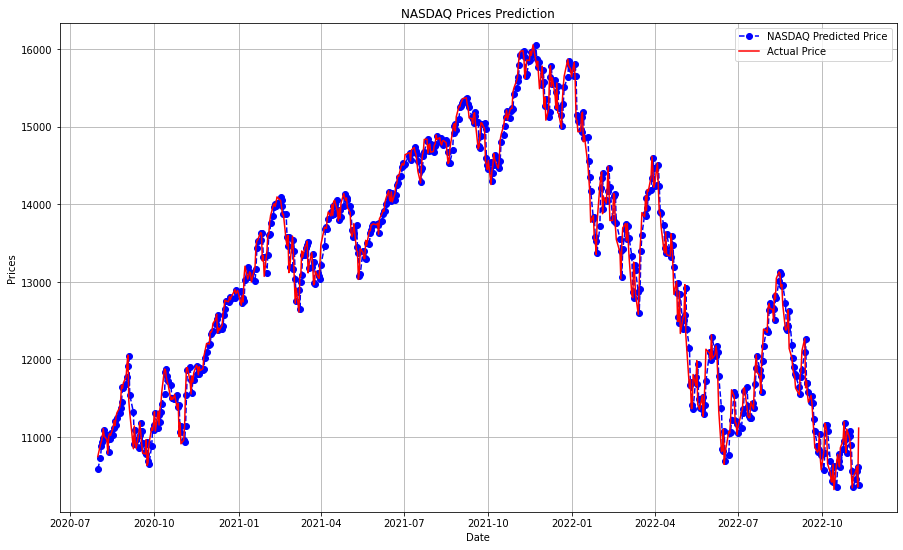

In [ ]:
plt.figure(figsize = (15,9))
plt.grid(True)
data_range = data[row:].index
plt.plot(data_range, model_predictions, color='blue',marker = 'o', linestyle = 'dashed', label='NASDAQ Predicted Price')
plt.plot(data_range, test, color='red', label='Actual Price')
plt.title('NASDAQ Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()